In [1]:
from models.tensorflow.deconvnet_v1 import *
from scripts import dataset, iterator
from scripts.config import *
from scripts.tools import *
import scripts.preprocessing as pp
from scripts.tf_tools import PixelWiseSoftmax_with_Loss
from IPython.display import clear_output

set_GPU("2")

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load Train dataset
tr_benign = dataset.LMDB(Class='benign', Phase='train', mode='read').dataset
tr_malignant = dataset.LMDB(Class='malignant', Phase='train', mode='read').dataset
tr_none = dataset.LMDB(Class='none', Phase='train', mode='read').dataset

# Load Test dataset
te_benign = dataset.LMDB(Class='benign', Phase='test', mode='read').dataset
te_malignant = dataset.LMDB(Class='malignant', Phase='test', mode='read').dataset
te_none = dataset.LMDB(Class='none', Phase='test', mode='read').dataset

In [3]:
tr_benign['roi']=pp.RoI_OHE(tr_benign['roi'],'benign')
tr_malignant['roi']=pp.RoI_OHE(tr_malignant['roi'],'malignant')
tr_none['roi']=pp.RoI_OHE(tr_none['roi'],'none')

te_benign['roi']=pp.RoI_OHE(te_benign['roi'],'benign')
te_malignant['roi']=pp.RoI_OHE(te_malignant['roi'],'malignant')
te_none['roi']=pp.RoI_OHE(te_none['roi'],'none')

In [4]:
train_img=np.concatenate((tr_benign['img'],tr_malignant['img'],tr_none['img']),axis=0)
train_roi=np.concatenate((tr_benign['roi'],tr_malignant['roi'],tr_none['roi']),axis=0)

test_img=np.concatenate((te_benign['img'],te_malignant['img'],te_none['img']),axis=0)
test_roi=np.concatenate((te_benign['roi'],te_malignant['roi'],te_none['roi']),axis=0)

train_indices=np.random.permutation(len(train_img))
test_indices=np.random.permutation(len(test_img))

train_img, train_roi = train_img[train_indices], train_roi[train_indices]
test_img, test_roi = test_img[test_indices], test_roi[test_indices]

In [5]:
# Prepare Network
tf.reset_default_graph()
Deconvnet = deconvnet((64,64,3), (64,64,3))

with Deconvnet.graph.as_default():
    saver = tf.train.Saver()

In [6]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.argmax(Deconvnet.y,axis=3),logits=Deconvnet.score))

optimizer = tf.train.AdadeltaOptimizer(learning_rate=1,rho=0.95,epsilon=1e-09).minimize(loss)

correct =tf.equal(tf.argmax(tf.transpose(Deconvnet.score,(3,0,1,2)),0),
                  tf.argmax(tf.transpose(Deconvnet.y,(3,0,1,2)),0))

accuracy=tf.reduce_mean(tf.cast(correct, tf.float32))

In [ ]:
tr_batch_num = int(train_img.shape[0]/100)+1
num_epochs=10000
snapshot_step=1000
batch_size=100

[Epochs : 52 ] Train - Accuracy : 0.98600 Train - Loss : 0.03406


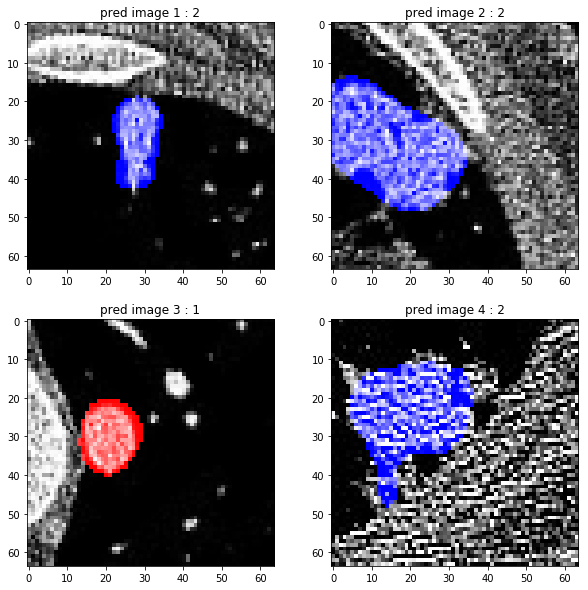

In [ ]:
with Deconvnet.sess as sess:
    with tf.device('/gpu:0'):
        sess.run(tf.global_variables_initializer())

        for epoch in range(num_epochs):

            train_acc = 0.
            train_loss = 0.
            train_count = 0
            for i in range(tr_batch_num):
                data = train_img[i*batch_size:(i+1)*batch_size] if i != tr_batch_num-1 else train_img[i*batch_size:]
                label = train_roi[i*batch_size:(i+1)*batch_size] if i != tr_batch_num-1 else train_roi[i*batch_size:]
                acc,cost,op = sess.run([accuracy,loss,optimizer], feed_dict={Deconvnet.x: data,
                                                                             Deconvnet.y: label, 
                                                                             Deconvnet.keep_prob: 0.7})
                train_acc += acc
                train_loss += cost
                train_count += 1

            if epoch%snapshot_step==0 and epoch !=0:
                saver.save(net.sess, "./snapshot/tensorflow/Deconvnet_"+str(step)+".ckpt")
            
            clear_output()
            fig, ((p11,p12),(p21,p22)) = plt.subplots(2,2)
            fig.set_size_inches(10, 10)
            
            print("[Epochs : "+str(epoch+1)+" ]"+
                  " Train - Accuracy : {:.5f}".format(train_acc/train_count if train_count !=0 else 0)+
                  " Train - Loss : {:.5f}".format(train_loss/train_count if train_count !=0 else 0))
            
            indices = np.random.choice(len(test_img),4)

            test_imgs=list()
            test_masks=list()
            for index in indices:
                test_imgs.append(test_img[index])
                test_masks.append(test_roi[index])
            test_imgs=np.array(test_imgs)
            test_masks=np.array(test_masks)

            pred_imgs=sess.run([Deconvnet.score], feed_dict={Deconvnet.x: test_imgs,
                                                             Deconvnet.keep_prob: 1.0})
            pred_imgs=sess.run(tf.argmax(tf.transpose(pred_imgs[0],(3,0,1,2)),0))
            
            for n in range(4):
                for i in range(test_imgs.shape[1]):
                    for j in range(test_imgs.shape[2]):
                        if pred_imgs[n,i,j]==1:
                            test_imgs[n,i,j,0]=255
                        elif pred_imgs[n,i,j]==2:
                            test_imgs[n,i,j,2]=255

            p11.set_title("pred image 1 : "+str(np.max(pred_imgs[0])))
            p11.imshow(test_imgs[0])
            p12.set_title("pred image 2 : "+str(np.max(pred_imgs[1])))
            p12.imshow(test_imgs[1])
            p21.set_title("pred image 3 : "+str(np.max(pred_imgs[2])))
            p21.imshow(test_imgs[2])
            p22.set_title("pred image 4 : "+str(np.max(pred_imgs[3])))
            p22.imshow(test_imgs[3])

            plt.show()